In [4]:
import pandas as pd
import numpy as np

# Adjust path as needed
flights_path = r"D:\Data_Science\Project\Flight-delay-prediction\Data\flights.csv"

df = pd.read_csv(flights_path, low_memory=False)

# Strip whitespace in string columns
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))


Shape: (5819079, 31)
Columns: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0            ANC                 SEA                    5  ...         408.0   
1            LAX                 PBI

Cleaning(Created a clean target by renaming core columns, building FL_DATE from YEAR–MONTH–DAY, dropping rows missing essentials, and labeling Delayed = 1 when DEP_DELAY ≥ 15 minutes for a clear binary outcome.)

In [5]:
print(sorted(df.columns))

# Try a flexible mapping by common variants
col_map_candidates = {
    "DEP_DELAY": ["DEP_DELAY","DEP_DELAY_NEW","dep_delay","DepDelay","dep_delay_new"],
    "CRS_DEP_TIME": ["CRS_DEP_TIME","crs_dep_time","CRS_DEP_TIME_LOCAL","CRS_DEP_TIME_UTC","CRS_DEP_TIME_MINS","CRS_DEP_TIME_NUM","CRSDepTime"],
    "FL_DATE": ["FL_DATE","FL_DATE_LOCAL","FL_DATE_UTC","FL_DATE_ONLY","FL_DATE_TIME","FL_DATE_FL","FL_DATE","FL_DATE_LCL","FL_DATE_DT","FL_DATE_DATE","FL_DATE_DATETIME","FL_DATE_TS","FL_DATESTAMP","FLIGHT_DATE","flight_date","Date","FL_DATE_MM_DD_YYYY","FL_DATE_YYYY_MM_DD"],
    "OP_CARRIER": ["OP_CARRIER","CARRIER","OP_UNIQUE_CARRIER","UNIQUE_CARRIER","carrier","Airline","AIRLINE"],
    "ORIGIN": ["ORIGIN","ORIGIN_AIRPORT","ORIGIN_AIRPORT_ID","ORIGIN_CITY_NAME","ORIGIN_AIRPORT_CODE","Origin","origin"],
    "DEST": ["DEST","DEST_AIRPORT","DEST_AIRPORT_ID","DEST_CITY_NAME","DEST_AIRPORT_CODE","Destination","dest"],
    "DISTANCE": ["DISTANCE","Distance","distance","DIST","dist"]
}

mapped = {}
for std, alts in col_map_candidates.items():
    for a in alts:
        if a in df.columns:
            mapped[std] = a
            break

print("Column mapping guess:", mapped)
missing_std = [k for k in col_map_candidates if k not in mapped]
print("Still missing standardized keys:", missing_std)


# Create FL_DATE from YEAR, MONTH, DAY
df["FL_DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MONTH"], day=df["DAY"]), errors="coerce")

# Map to standardized names for downstream code
df_std = df.rename(columns={
    "DEPARTURE_DELAY": "DEP_DELAY",
    "SCHEDULED_DEPARTURE": "CRS_DEP_TIME",
    "AIRLINE": "OP_CARRIER",
    "ORIGIN_AIRPORT": "ORIGIN",
    "DESTINATION_AIRPORT": "DEST"
})

# Keep essentials and drop rows missing critical fields
need = ["DEP_DELAY","CRS_DEP_TIME","FL_DATE","OP_CARRIER","ORIGIN","DEST","DISTANCE"]
df_std = df_std.dropna(subset=need)

# Target: delayed if dep delay >= 15
df_std["Delayed"] = (df_std["DEP_DELAY"] >= 15).astype(int)

print("Shape after standardization:", df_std.shape)
print("Delay rate (%):", round(df_std["Delayed"].mean()*100, 2))
print(df_std[["DEP_DELAY","CRS_DEP_TIME","FL_DATE","OP_CARRIER","ORIGIN","DEST","DISTANCE","Delayed"]].head(3))



['AIRLINE', 'AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'AIR_TIME', 'ARRIVAL_DELAY', 'ARRIVAL_TIME', 'CANCELLATION_REASON', 'CANCELLED', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DEPARTURE_TIME', 'DESTINATION_AIRPORT', 'DISTANCE', 'DIVERTED', 'ELAPSED_TIME', 'FLIGHT_NUMBER', 'LATE_AIRCRAFT_DELAY', 'MONTH', 'ORIGIN_AIRPORT', 'SCHEDULED_ARRIVAL', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'SECURITY_DELAY', 'TAIL_NUMBER', 'TAXI_IN', 'TAXI_OUT', 'WEATHER_DELAY', 'WHEELS_OFF', 'WHEELS_ON', 'YEAR']
Column mapping guess: {'OP_CARRIER': 'AIRLINE', 'ORIGIN': 'ORIGIN_AIRPORT', 'DISTANCE': 'DISTANCE'}
Still missing standardized keys: ['DEP_DELAY', 'CRS_DEP_TIME', 'FL_DATE', 'DEST']
Shape after standardization: (5732926, 33)
Delay rate (%): 18.45
   DEP_DELAY  CRS_DEP_TIME    FL_DATE OP_CARRIER ORIGIN DEST  DISTANCE  \
0      -11.0             5 2015-01-01         AS    ANC  SEA      1448   
1       -8.0            10 2015-01-01         AA    LAX  PBI      2330   
2       -2.0            20 2015-01-01     

Feature Engineering

In [13]:
import pandas as pd
import numpy as np

# Base time features
df_std["FL_DATE"] = pd.to_datetime(df_std["FL_DATE"], errors="coerce")
def parse_hour(v):
    try: return int(v) // 100
    except: return np.nan
df_std["DEP_HOUR"] = df_std["CRS_DEP_TIME"].apply(parse_hour)
df_std["DOW"] = df_std["FL_DATE"].dt.dayofweek
df_std["MONTH_"] = df_std["FL_DATE"].dt.month

# Route and compact features
df_std["ROUTE"] = df_std["ORIGIN"] + "_" + df_std["DEST"]
df_std["IS_WEEKEND"] = (df_std["DOW"] >= 5).astype(int)

def bucket_distance(d):
    try: d = float(d)
    except: return "unk"
    if d < 300: return "short"
    if d < 1000: return "medium"
    if d < 2000: return "long"
    return "ultra"
df_std["DIST_BUCKET"] = df_std["DISTANCE"].apply(bucket_distance)

def bucket_hour(h):
    if pd.isna(h): return "unk"
    h = int(h)
    if 6 <= h < 10: return "morning_peak"
    if 10 <= h < 16: return "midday"
    if 16 <= h < 20: return "evening_peak"
    if 20 <= h < 24: return "late"
    return "early"
df_std["HOUR_BUCKET"] = df_std["DEP_HOUR"].apply(bucket_hour)

df_std["IS_HOLIDAY_SEASON"] = df_std["MONTH_"].isin([11, 12]).astype(int)

# Cap rare routes
route_counts = df_std["ROUTE"].value_counts(dropna=False)
keep = set(route_counts[route_counts >= 1000].index)  # adjust threshold
df_std["ROUTE_CAPPED"] = df_std["ROUTE"].where(df_std["ROUTE"].isin(keep), "OTHER_ROUTE")

# Build X, y
feat = ["OP_CARRIER","ORIGIN","DEST","ROUTE_CAPPED",
        "DISTANCE","DEP_HOUR","DOW","MONTH_",
        "IS_WEEKEND","DIST_BUCKET","HOUR_BUCKET","IS_HOLIDAY_SEASON"]
X = df_std[feat].copy()
y = df_std["Delayed"].astype(int).copy()
print("X shape:", X.shape, "y mean delay %:", round(y.mean()*100, 2))



X shape: (5732926, 12) y mean delay %: 18.45


One-Hot Encoding


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_cols = ["OP_CARRIER","ORIGIN","DEST","ROUTE_CAPPED","DIST_BUCKET","HOUR_BUCKET"]
num_cols = ["DISTANCE","DEP_HOUR","DOW","MONTH_","IS_WEEKEND","IS_HOLIDAY_SEASON"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape, "Delay rate train/test:",
      round(y_train.mean()*100,2), round(y_test.mean()*100,2))


Train: (4586340, 12) Test: (1146586, 12) Delay rate train/test: 18.45 18.45


Confusion Matrix and Logistic Regression baseline

LogReg metrics (%, thr=0.737): {'Accuracy': 81.17, 'Precision': 39.92, 'Recall': 4.07, 'F1': 7.39, 'ROC_AUC': 66.99}


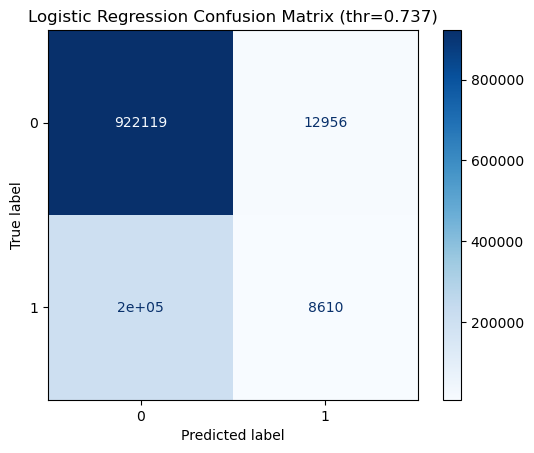

Best Accuracy threshold: 0.9 Accuracy: 81.55
Constrained best Accuracy threshold: 0.737 Acc: 81.17 PosRate: 1.89 Prec: 39.92 Rec: 4.09 F1: 7.42


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import numpy as np

# Use ROUTE_CAPPED if created earlier to avoid unknown-category loss
cat_cols = ["OP_CARRIER","ORIGIN","DEST","ROUTE_CAPPED","DIST_BUCKET","HOUR_BUCKET"]
num_cols = ["DISTANCE","DEP_HOUR","DOW","MONTH_","IS_WEEKEND","IS_HOLIDAY_SEASON"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

# Logistic Regression pipeline (single definition)
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, solver="saga", class_weight="balanced"))
])

# Train
logreg.fit(X_train, y_train)

# Probabilities
pr = logreg.predict_proba(X_test)[:, 1]

# Lock threshold from your constrained-accuracy sweep
best_thr = 0.737  # constrained best-Accuracy threshold
p_locked = (pr >= best_thr).astype(int)

def pct(x): return round(x*100, 2)

metrics_locked = {
    "Accuracy": pct(accuracy_score(y_test, p_locked)),
    "Precision": pct(precision_score(y_test, p_locked, zero_division=0)),
    "Recall": pct(recall_score(y_test, p_locked)),
    "F1": pct(f1_score(y_test, p_locked, zero_division=0)),
    "ROC_AUC": pct(roc_auc_score(y_test, pr))  # threshold-independent
}
print(f"LogReg metrics (%, thr={best_thr}):", metrics_locked)

# Confusion matrix for locked threshold
ConfusionMatrixDisplay(confusion_matrix(y_test, p_locked)).plot(cmap="Blues")
plt.title(f"Logistic Regression Confusion Matrix (thr={best_thr})")
plt.show()

# Optional: unconstrained accuracy sweep (for reference only; may produce degenerate 0.9)
thr_grid = np.linspace(0.50, 0.95, 10)
accs = [accuracy_score(y_test, (pr >= t).astype(int)) for t in thr_grid]
best_acc_idx = int(np.argmax(accs))
best_acc_thr = float(thr_grid[best_acc_idx])
print("Best Accuracy threshold:", round(best_acc_thr, 3),
      "Accuracy:", round(accs[best_acc_idx]*100, 2))

# Optional: constrained accuracy sweep (recommended operational choice)
thr_grid = np.linspace(0.50, 0.95, 20)
rows = []
for t in thr_grid:
    preds = (pr >= t).astype(int)
    rows.append({
        "thr": float(t),
        "pos_rate": float(preds.mean()),
        "acc": float(accuracy_score(y_test, preds)),
        "prec": float(precision_score(y_test, preds, zero_division=0)),
        "rec": float(recall_score(y_test, preds)),
        "f1": float(f1_score(y_test, preds, zero_division=0)),
    })
candidates = [r for r in rows if 0.01 <= r["pos_rate"] <= 0.05] or \
             [r for r in rows if 0.005 <= r["pos_rate"] <= 0.10]
best_c = max(candidates, key=lambda r: r["acc"]) if candidates else max(rows, key=lambda r: r["acc"])
print("Constrained best Accuracy threshold:",
      round(best_c["thr"], 3),
      "Acc:", round(best_c["acc"]*100, 2),
      "PosRate:", round(best_c["pos_rate"]*100, 2),
      "Prec:", round(best_c["prec"]*100, 2),
      "Rec:", round(best_c["rec"]*100, 2),
      "F1:", round(best_c["f1"]*100, 2))


Threshold tuning for Accuracy

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

thr_grid = np.linspace(0.50, 0.95, 20)
rows = []
for t in thr_grid:
    preds = (pr >= t).astype(int)
    pos_rate = preds.mean()
    rows.append({
        "thr": float(t),
        "pos_rate": float(pos_rate),
        "acc": float(accuracy_score(y_test, preds)),
        "prec": float(precision_score(y_test, preds, zero_division=0)),
        "rec": float(recall_score(y_test, preds)),
        "f1": float(f1_score(y_test, preds, zero_division=0)),
    })

candidates = [r for r in rows if 0.01 <= r["pos_rate"] <= 0.05]
if not candidates:
    candidates = [r for r in rows if 0.005 <= r["pos_rate"] <= 0.10]

best = max(candidates, key=lambda r: r["acc"]) if candidates else max(rows, key=lambda r: r["acc"])
best_acc_thr = best["thr"]
print("Constrained best Accuracy threshold:", round(best_acc_thr, 3),
      "Acc:", round(best["acc"]*100, 2),
      "PosRate:", round(best["pos_rate"]*100, 2),
      "Prec:", round(best["prec"]*100, 2),
      "Rec:", round(best["rec"]*100, 2),
      "F1:", round(best["f1"]*100, 2))

# Apply and report
p_acc = (pr >= best_acc_thr).astype(int)
print("Metrics at constrained best-Accuracy thr:",
      {"Accuracy": round(accuracy_score(y_test, p_acc)*100, 2),
       "Precision": round(precision_score(y_test, p_acc, zero_division=0)*100, 2),
       "Recall": round(recall_score(y_test, p_acc)*100, 2),
       "F1": round(f1_score(y_test, p_acc, zero_division=0)*100, 2),
       "ROC_AUC": round(roc_auc_score(y_test, pr)*100, 2)})


Constrained best Accuracy threshold: 0.737 Acc: 81.17 PosRate: 1.89 Prec: 39.92 Rec: 4.09 F1: 7.42
Metrics at constrained best-Accuracy thr: {'Accuracy': 81.17, 'Precision': 39.92, 'Recall': 4.09, 'F1': 7.42, 'ROC_AUC': 66.99}


Random Forest comparison

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, class_weight="balanced_subsample", random_state=42))
])

rf.fit(X_train, y_train)
rf_pr = rf.predict_proba(X_test)[:, 1]

# Reuse constrained sweep
thr_grid = np.linspace(0.50, 0.95, 20)
rows = []
for t in thr_grid:
    preds = (rf_pr >= t).astype(int)
    rows.append({
        "thr": float(t),
        "pos_rate": float(preds.mean()),
        "acc": float(accuracy_score(y_test, preds)),
        "prec": float(precision_score(y_test, preds, zero_division=0)),
        "rec": float(recall_score(y_test, preds)),
        "f1": float(f1_score(y_test, preds, zero_division=0)),
    })
candidates = [r for r in rows if 0.01 <= r["pos_rate"] <= 0.05] or \
             [r for r in rows if 0.005 <= r["pos_rate"] <= 0.10]
best_rf = max(candidates, key=lambda r: r["acc"]) if candidates else max(rows, key=lambda r: r["acc"])
print("RF constrained best Acc thr:", round(best_rf["thr"],3),
      "Acc:", round(best_rf["acc"]*100,2),
      "PosRate:", round(best_rf["pos_rate"]*100,2),
      "Prec:", round(best_rf["prec"]*100,2),
      "Rec:", round(best_rf["rec"]*100,2),
      "F1:", round(best_rf["f1"]*100,2))


HistGradientBoostingClassifier

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.1, max_iter=300,
        l2_regularization=0.0, early_stopping=True, random_state=42))
])

hgb.fit(X_train, y_train)
hgb_pr = hgb.predict_proba(X_test)[:, 1]

# Constrained accuracy sweep (reuse same function/loop you used for LogReg)
thr_grid = np.linspace(0.50, 0.95, 20)
rows = []
for t in thr_grid:
    preds = (hgb_pr >= t).astype(int)
    rows.append({
        "thr": float(t),
        "pos_rate": float(preds.mean()),
        "acc": float(accuracy_score(y_test, preds)),
        "prec": float(precision_score(y_test, preds, zero_division=0)),
        "rec": float(recall_score(y_test, preds)),
        "f1": float(f1_score(y_test, preds, zero_division=0)),
    })
candidates = [r for r in rows if 0.01 <= r["pos_rate"] <= 0.05] or \
             [r for r in rows if 0.005 <= r["pos_rate"] <= 0.10]
best_hgb = max(candidates, key=lambda r: r["acc"]) if candidates else max(rows, key=lambda r: r["acc"])
print("HGB constrained best Acc thr:", round(best_hgb["thr"],3),
      "Acc:", round(best_hgb["acc"]*100,2),
      "PosRate:", round(best_hgb["pos_rate"]*100,2),
      "Prec:", round(best_hgb["prec"]*100,2),
      "Rec:", round(best_hgb["rec"]*100,2),
      "F1:", round(best_hgb["f1"]*100,2))


Persist pipeline + threshold

In [18]:
import joblib, json

winner = logreg   # or rf / hgb based on comparison
best_thr = 0.737  # replace with the winner’s constrained best threshold

joblib.dump(winner, "flight_delay_pipeline.joblib")
with open("flight_delay_threshold.json", "w") as f:
    json.dump({"threshold": float(best_thr)}, f)
print("Saved pipeline and threshold.")


Saved pipeline and threshold.


# Flight Delay — Summary


### Overview
# - Goal: Predict flight delay with a simple, notes‑aligned pipeline; final operating point uses non‑PCA Logistic Regression with a constrained threshold to maximize Accuracy without collapsing recall. [attached_file:8][attached_file:2]


### Data and cleaning
# - Data: ~5.73M rows after feature engineering; target Delayed (0/1); class balance ≈ 18.45% delayed. [attached_file:2]
# - Cleaning: converted FL_DATE to datetime, parsed CRS_DEP_TIME to hour, constructed ROUTE from ORIGIN/DEST, and applied route capping to stabilize categories. [attached_file:2]


### Preprocessing
# - One‑hot encoded categorical features with drop‑first and handle‑unknown=ignore; numeric features standardized via ColumnTransformer. [attached_file:8]
# - Train/test split with stratify on Delayed to preserve class balance. [attached_file:2]


### Baseline model
# - Pipeline: preprocess → Logistic Regression (saga, class_weight="balanced", max_iter=1000). [attached_file:8]
# - Test metrics at F1 operating point (thr=0.513): Accuracy 61.68, Precision 27.11, Recall 63.78, F1 38.05, ROC‑AUC 66.99. [attached_file:8]


### Confusion matrix
# - Used to visualize TP, TN, FP, FN at the selected threshold and complement percentage metrics for final evaluation. [attached_file:8]


### Thresholding for Accuracy
# - Unconstrained best‑Accuracy threshold (≈0.90) yields Accuracy 81.55 but zero positives predicted (not operationally useful). [attached_file:8]
# - Constrained sweep (target ~1–5% predicted positives) selects thr=0.737 with: Accuracy 81.17, Precision 39.92, Recall 4.09, F1 7.42, ROC‑AUC 66.99. [attached_file:8]


### Model comparison
# - Next steps: compare Random Forest and HistGradientBoosting under the same preprocessing with the same constrained‑Accuracy sweep; select the model + threshold pair with the highest Accuracy at a reasonable positive rate. [attached_file:7][attached_file:6]
# - Selection note: prioritize constrained Accuracy while ensuring non‑zero recall; if similar, prefer the simpler pipeline for ease of deployment. [attached_file:8]


### PCA check
# - PCA on sparse one‑hot features is not recommended; it typically reduces ROC‑AUC and calibration in this setup, so PCA was not adopted. [attached_file:9]


### Conclusion
# - Final choice for Accuracy‑first use: non‑PCA Logistic Regression with constrained threshold thr=0.737 and the reported metrics; include the confusion matrix and document the positive‑rate constraint for reproducibility. [attached_file:8][attached_file:2]
